In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist

In [3]:
X_train.shape , X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
X_train, X_test = X_train / 255. , X_test / 255.

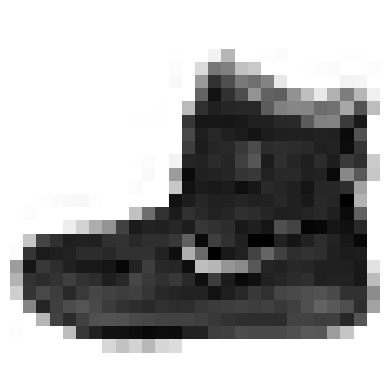

In [5]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [8]:
n_objects = len(np.unique(y_train))
print(n_objects)

10


In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

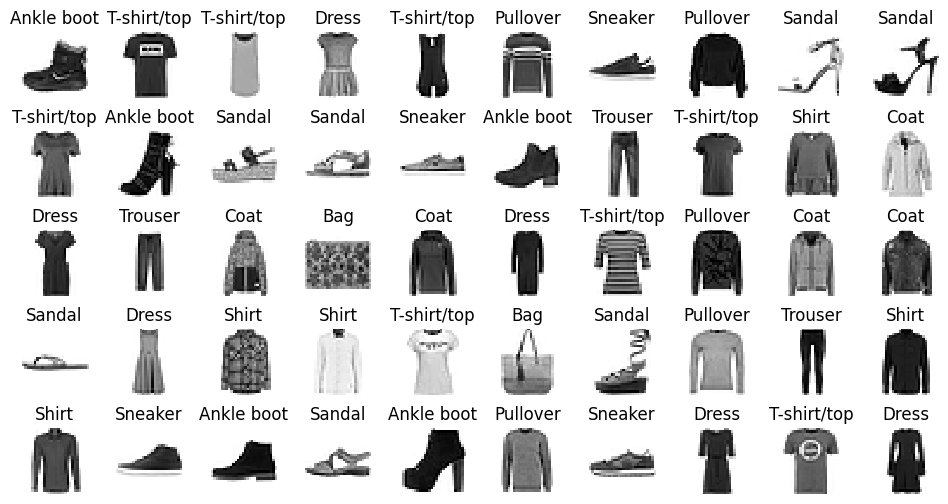

In [7]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [9]:
# convert each image to 1 dimensional array
X = X_train.reshape(len(X_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [10]:
kmeans = MiniBatchKMeans(n_clusters=n_objects)
kmeans.fit(X)

MiniBatchKMeans(n_clusters=10)

In [11]:
kmeans.labels_

array([4, 9, 7, ..., 2, 7, 1])

In [14]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [16]:
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:35])
print(Y[:35])

[9 0 0 0 1 2 5 2 0 9 0 9 5 5 5 9 1 0 2 0 1 1 3 8 2 3 0 2 8 2 5 0 2 0 0]
[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0]


In [17]:
def calculate_metrics(estimator, data, labels):
    
    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [18]:
clusters = [ 5*x for x in range(1,26)]

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 5
Inertia: 37.00710957557788
Homogeneity: 0.35108863349930186
Accuracy: 0.39641666666666664

Number of Clusters: 10
Inertia: 30.10732610213732
Homogeneity: 0.4798347489935901
Accuracy: 0.49915

Number of Clusters: 15
Inertia: 26.717710699579946
Homogeneity: 0.5613994111063072
Accuracy: 0.6175333333333334

Number of Clusters: 20
Inertia: 24.95346003363362
Homogeneity: 0.6039877700312154
Accuracy: 0.65555

Number of Clusters: 25
Inertia: 23.911521656893946
Homogeneity: 0.6139167319254327
Accuracy: 0.6484666666666666

Number of Clusters: 30
Inertia: 22.941503289895962
Homogeneity: 0.6376964036996167
Accuracy: 0.6815666666666667

Number of Clusters: 35
Inertia: 22.471759446888605
Homogeneity: 0.6432920635046722
Accuracy: 0.6829166666666666

Number of Clusters: 40
Inertia: 21.878779323589427
Homogeneity: 0.6459440275856573
Accuracy: 0.6793166666666667

Number of Clusters: 45
Inertia: 21.471409298769697
Homogeneity: 0.6623954854268281
Accuracy: 0.69835

Number of Clusters

In [19]:
def plot_inertia(data, clusters):
    inertias = []
    
    for n_clusters in clusters:
        estimator = MiniBatchKMeans(n_clusters=n_clusters)
        estimator.fit(data)
        inertias.append(estimator.inertia_)
    
    plt.plot(clusters, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Number of Clusters vs. Inertia')
    plt.show()

In [25]:
def plot_accuracy(data, labels, cluster = clusters):
    inertias = []
    
    for n_clusters in cluster:
        estimator = MiniBatchKMeans(n_clusters=n_clusters)
        estimator.fit(data)
        inertias.append(metrics.homogeneity_score(labels, estimator.labels_))
    
    plt.plot(cluster, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Accuracy')
    plt.title('Number of Clusters vs. Accuracy')
    plt.show()

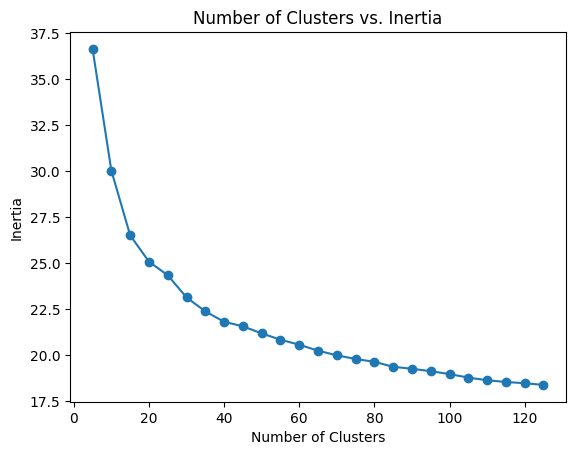

In [26]:
plot_inertia(X, clusters)

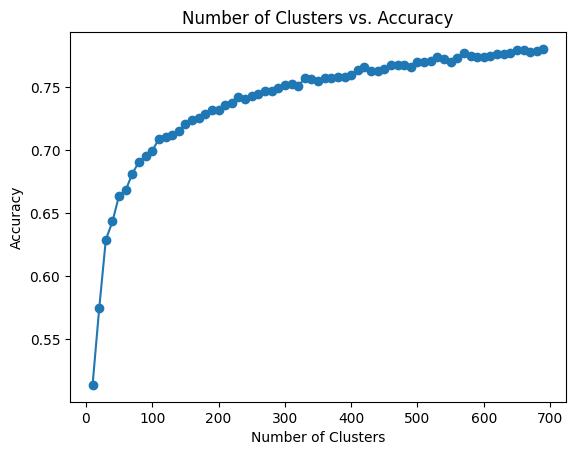

In [29]:
clusters = [ 10*x for x in range(1,70)]

plot_accuracy(X, Y, clusters)

C:\Users\NewSunPC\AppData\Local\Temp\ipykernel_16084\197284882.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


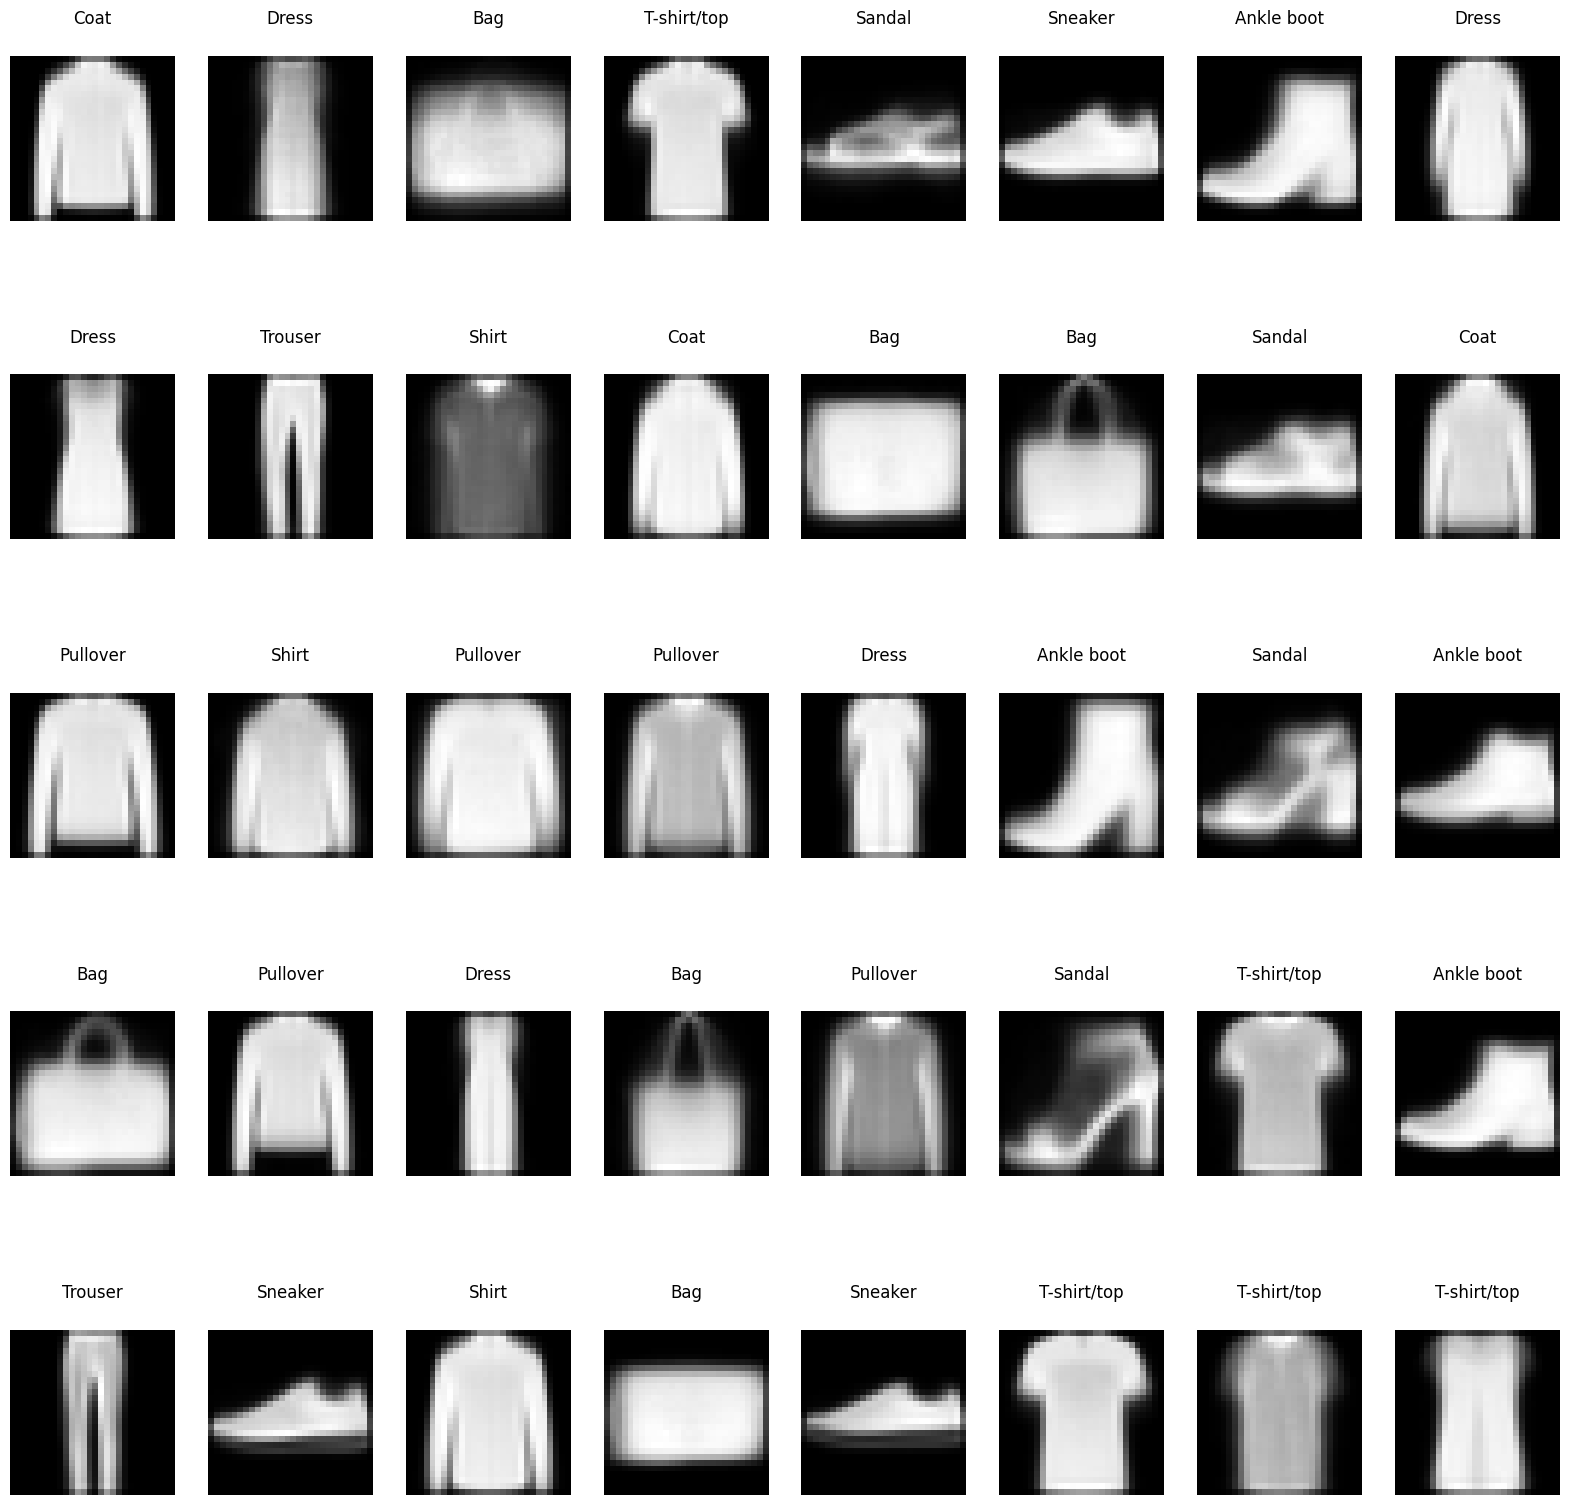

In [48]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 40)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(40, 28, 28)
#images *= 255
#images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(5, 8, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title((class_names[key]))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()